In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, average_precision_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.integration import XGBoostPruningCallback
import warnings
warnings.filterwarnings('ignore')

## 1. Load Processed Data (feature engineering; 24h; aggregation)

In [2]:
df_agg = pd.read_csv('../../data/mimic_dataset_24h_aggregated.csv')
df_agg.head()

,gender,age,elixhauser,re_admission,Height_cm,Weight_kg,mechvent_mean,mechvent_max,extubated_mean,extubated_max,...,SOFA_min,SOFA_max,SOFA_std,SOFA_last,SIRS_mean,SIRS_min,SIRS_max,SIRS_std,SIRS_last,died_in_hosp
0,1,61,1,0,173.00,115.0,0.000000,0,0.0,0,...,13,13,NaN,13,1.000000,1,1,NaN,1,0
1,1,92,4,1,163.00,68.5,0.000000,0,0.0,0,...,2,8,2.225395,5,2.285714,1,4,0.951190,2,0
2,1,78,9,0,182.88,90.0,0.714286,1,0.0,0,...,5,8,0.975900,7,2.571429,2,3,0.534522,2,0
3,1,56,4,0,178.00,119.3,0.000000,0,0.0,0,...,8,9,0.534522,9,2.000000,0,3,1.000000,0,0
4,0,61,8,0,180.34,78.4,0.000000,0,0.0,0,...,9,11,0.707107,10,1.800000,1,2,0.447214,2,1


In [3]:
df_agg['died_in_hosp'].sum()/df_agg.shape[0]

0.1646249139710943

## 2. Define X and y

In [4]:
target_col = 'died_in_hosp'
y = df_agg[target_col].astype(int)
X = df_agg.drop(columns=[target_col])

## 3. Data Splitting  
- Divide the dataset into the training set and the test set, with an 80/20 ratio.
- To ensure that the proportion of deceased/survived patients in the training set and the test set is consistent with the original data, `stratified sampling` is adopted.

In [6]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=test_size, 
    random_state=42, 
    stratify=y
)

print(f"Size of the training set: {X_train.shape}")
print(f"Size of the testing set: {X_test.shape}")
print(f"Training set mortality rate: {y_train.mean():.3f}")
print(f"Testing set mortality rate: {y_test.mean():.3f}")

Size of the training set: (23248, 325)
Size of the testing set: (5812, 325)
Training set mortality rate: 0.165
Testing set mortality rate: 0.165


## 4. Missing Value Imputation

- For numerical features, using the median is often more robust than the mean, as it is not affected by outliers. For categorical features, the mode can be used. 
    
- The imputation values are calculated only on the training set and then applied to both the training and testing sets to prevent data leakage.

In [7]:
print(f"Proportion of missing values:")
missing_proportion = (X.isnull().sum()/X.shape[0]).sort_values(ascending=False) 
print(missing_proportion)

Proportion of missing values:
ETCO2_std          0.087027
ETCO2_mean         0.056435
ETCO2_min          0.056435
ETCO2_max          0.056435
ETCO2_last         0.056435
                     ...   
Potassium_max      0.000000
Potassium_min      0.000000
Potassium_mean     0.000000
PAWplateau_last    0.000000
SIRS_last          0.000000
Length: 325, dtype: float64


In [8]:
imputer = SimpleImputer(strategy='median')

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

## 5. Feature Scaling    
    
XGBoost does not require feature scaling because it is a tree-based model.   

## 6. XGBoost Model Training and Hyperparameter Tuning

In [9]:
# calculate the category weights to handle imbalanced data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Category weight: {scale_pos_weight:.2f}")

Category weight: 5.07


In [ ]:
def objective(trial):
    """
    Optuna objective function for XGBoost hyperparameter optimization.
    """
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',  # better for imbalanced data
        'tree_method': 'hist',
        'scale_pos_weight': scale_pos_weight,  # handle imbalanced data
        'random_state': 42,
        
        # Hyperparameter search space
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10), 
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1.0),  # reduce overfitting
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2.0),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2.0),  # L2 regularization
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 5),  # helpful for imbalanced data
    }
    
    # use StratifiedKFold for cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores_auc = []
    cv_scores_aucpr = []  # AUCPR is more relevant for imbalanced data
    train_scores = []  # monitor training performance for overfitting analysis
    
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_imputed, y_train)):
        X_fold_train = X_train_imputed[train_idx]
        y_fold_train = y_train.iloc[train_idx]
        X_fold_val = X_train_imputed[val_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        model = xgb.XGBClassifier(**params)
        
        model.fit(
            X_fold_train, y_fold_train,
            eval_set=[(X_fold_train, y_fold_train), (X_fold_val, y_fold_val)],
            verbose=False
        )
        
        # calculate metrics on training and validation sets
        y_train_proba = model.predict_proba(X_fold_train)[:, 1]
        y_val_proba = model.predict_proba(X_fold_val)[:, 1]
        
        train_auc = roc_auc_score(y_fold_train, y_train_proba)
        val_auc = roc_auc_score(y_fold_val, y_val_proba)
        val_aucpr = average_precision_score(y_fold_val, y_val_proba)  # AUPR is main metric, better for imbalanced data
        
        train_scores.append(train_auc)
        cv_scores_auc.append(val_auc)
        cv_scores_aucpr.append(val_aucpr)
        
        # Optuna pruning: if the intermediate AUPR is not promising, prune the trial
        trial.report(val_aucpr, fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    mean_cv_auc = np.mean(cv_scores_auc)
    mean_cv_aucpr = np.mean(cv_scores_aucpr)  # main evaluation metric
    mean_train_score = np.mean(train_scores)
    
    # overfitting penalty
    overfitting_penalty = abs(mean_train_score - mean_cv_auc)
    if overfitting_penalty > 0.05:  
        mean_cv_aucpr -= overfitting_penalty * 0.5  
    
    trial.set_user_attr('mean_train_auc', mean_train_score)
    trial.set_user_attr('mean_val_auc', mean_cv_auc)
    trial.set_user_attr('mean_val_aucpr', mean_cv_aucpr)
    trial.set_user_attr('overfitting_gap', overfitting_penalty)
    
    return mean_cv_aucpr  

In [15]:
print("Starting hyperparameter optimization with Optuna...")
print("=" * 60)

# create study
study = optuna.create_study(
    direction='maximize',  # maximize AUCPR
    sampler=optuna.samplers.TPESampler(seed=42),  # use TPE sampler
    pruner=optuna.pruners.MedianPruner(  # median pruner
        n_startup_trials=10,  # first 10 trials no pruning
        n_warmup_steps=20,    # first 20 steps no pruning
        interval_steps=10     # check pruning every 10 steps
    )
)

study.optimize(objective, n_trials=100, show_progress_bar=True)

print("\nFinish.")
print("=" * 60)


[I 2025-10-16 12:12:47,933] A new study created in memory with name: no-name-1d0982de-e395-4416-8514-4bc0fbc57a9c


Starting hyperparameter optimization with Optuna...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-16 12:14:35,349] Trial 0 finished with value: 0.4935873702519221 and parameters: {'max_depth': 5, 'learning_rate': 0.2536999076681772, 'n_estimators': 800, 'min_child_weight': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 0.05808361216819946, 'reg_alpha': 1.7323522915498704, 'reg_lambda': 1.2022300234864176, 'max_delta_step': 4}. Best is trial 0 with value: 0.4935873702519221.
[I 2025-10-16 12:15:52,887] Trial 1 finished with value: 0.47953776371212375 and parameters: {'max_depth': 3, 'learning_rate': 0.2708160864249968, 'n_estimators': 900, 'min_child_weight': 3, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'gamma': 0.3042422429595377, 'reg_alpha': 1.0495128632644757, 'reg_lambda': 0.8638900372842315, 'max_delta_step': 1}. Best is trial 0 with value: 0.4935873702519221.
[I 2025-10-16 12:17:01,538] Trial 2 finished with value: 0.5487384220373394 and parameters: {'max_depth': 6, 'learning_rate': 0.0160712385120

In [16]:
best_params = study.best_params
best_score = study.best_value

print(f"\nbest trial AUC-PR: {best_score:.4f}")
print(f"\nbest hyperparameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

best_trial = study.best_trial
print(f"\nbest trial details:")
print(f"  training set average AUC: {best_trial.user_attrs['mean_train_auc']:.4f}")
print(f"  testing set average AUC: {best_trial.user_attrs['mean_val_auc']:.4f}")
print(f"  testing set average AUC-PR: {best_trial.user_attrs['mean_val_aucpr']:.4f}")
print(f"  overfitting gap: {best_trial.user_attrs['overfitting_gap']:.4f}")


best trial AUC-PR: 0.5974

best hyperparameters:
  max_depth: 3
  learning_rate: 0.02380863088307413
  n_estimators: 500
  min_child_weight: 2
  subsample: 0.9440163417454058
  colsample_bytree: 0.9085509070490112
  gamma: 0.1373924206305424
  reg_alpha: 0.8425569903599178
  reg_lambda: 1.330349258851893
  max_delta_step: 4

best trial details:
  training set average AUC: 0.9023
  testing set average AUC: 0.8524
  testing set average AUC-PR: 0.5974
  overfitting gap: 0.0499


In [17]:
best_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr', 
    tree_method='hist',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    **best_params
)

best_xgb.fit(
    X_train_imputed, y_train,
    eval_set=[(X_train_imputed, y_train), (X_test_imputed, y_test)],
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9085509070490112, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, feature_weights=None,
              gamma=0.1373924206305424, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02380863088307413,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=4, max_depth=3, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

## 7. Model Evaluation

In [28]:
y_train_pred = best_xgb.predict(X_train_imputed)
y_test_pred = best_xgb.predict(X_test_imputed)
y_train_proba = best_xgb.predict_proba(X_train_imputed)[:, 1]
y_test_proba = best_xgb.predict_proba(X_test_imputed)[:, 1]

print("training set performance:")
print(f"  Accuracy: {best_xgb.score(X_train_imputed, y_train):.4f}")
train_auc = roc_auc_score(y_train, y_train_proba)
train_auprc = average_precision_score(y_train, y_train_proba)
print(f"  AUC-ROC: {train_auc:.4f}")
print(f"  AUPRC: {train_auprc:.4f}")
print(classification_report(y_train, y_train_pred))


print("testing set performance:")
test_auc = roc_auc_score(y_test, y_test_proba)
test_auprc = average_precision_score(y_test, y_test_proba)
print(f"  Accuracy: {best_xgb.score(X_test_imputed, y_test):.4f}")
print(f"  AUC-ROC: {test_auc:.4f}")
print(f"  AUPRC: {test_auprc:.4f}")
print(classification_report(y_test, y_test_pred))

print(f"\noverfitting gap (AUC): {train_auc - test_auc:.4f}")


training set performance:
  Accuracy: 0.8142
  AUC-ROC: 0.8949
  AUPRC: 0.6805
              precision    recall  f1-score   support

           0       0.96      0.82      0.88     19421
           1       0.46      0.81      0.59      3827

    accuracy                           0.81     23248
   macro avg       0.71      0.81      0.73     23248
weighted avg       0.87      0.81      0.83     23248

testing set performance:
  Accuracy: 0.8004
  AUC-ROC: 0.8637
  AUPRC: 0.6149
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      4855
           1       0.44      0.76      0.56       957

    accuracy                           0.80      5812
   macro avg       0.69      0.78      0.71      5812
weighted avg       0.86      0.80      0.82      5812


overfitting gap (AUC): 0.0313


## 8. Feature Importance Analysis

In [19]:
feature_names = X.columns.tolist()

# 1. Information Gain
importance_gain = best_xgb.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'feature': list(importance_gain.keys()),
    'importance_gain': list(importance_gain.values())
})

feature_mapping = {f'f{i}': name for i, name in enumerate(feature_names)}
importance_df['feature_name'] = importance_df['feature'].map(feature_mapping)
importance_df = importance_df.sort_values('importance_gain', ascending=False)

print(f"\nTop 20 features by Information Gain:")
for i, row in importance_df.head(20).iterrows():
    print(f"{row['feature_name']:30s}: {row['importance_gain']:10.2f}")

# 2. Weight (split count)
importance_weight = best_xgb.get_booster().get_score(importance_type='weight')
importance_weight_df = pd.DataFrame({
    'feature': list(importance_weight.keys()),
    'importance_weight': list(importance_weight.values())
})
importance_weight_df['feature_name'] = importance_weight_df['feature'].map(feature_mapping)
importance_weight_df = importance_weight_df.sort_values('importance_weight', ascending=False)


Top 20 features by Information Gain:
SOFA_last                     :     996.82
SOFA_min                      :     950.85
SOFA_mean                     :     742.25
GCS_last                      :     541.98
median_dose_vaso_last         :     505.93
output_step_max               :     426.19
FiO2_1_last                   :     335.16
max_dose_vaso_last            :     333.69
RASS_last                     :     308.12
FiO2_100_last                 :     286.50
SIRS_last                     :     285.69
BUN_last                      :     282.70
output_step_mean              :     273.87
extubated_max                 :     246.38
O2flow_last                   :     226.28
SIRS_mean                     :     222.99
Arterial_lactate_min          :     193.93
SIRS_min                      :     187.51
extubated_mean                :     164.32
elixhauser                    :     154.99


## 9. Visualization

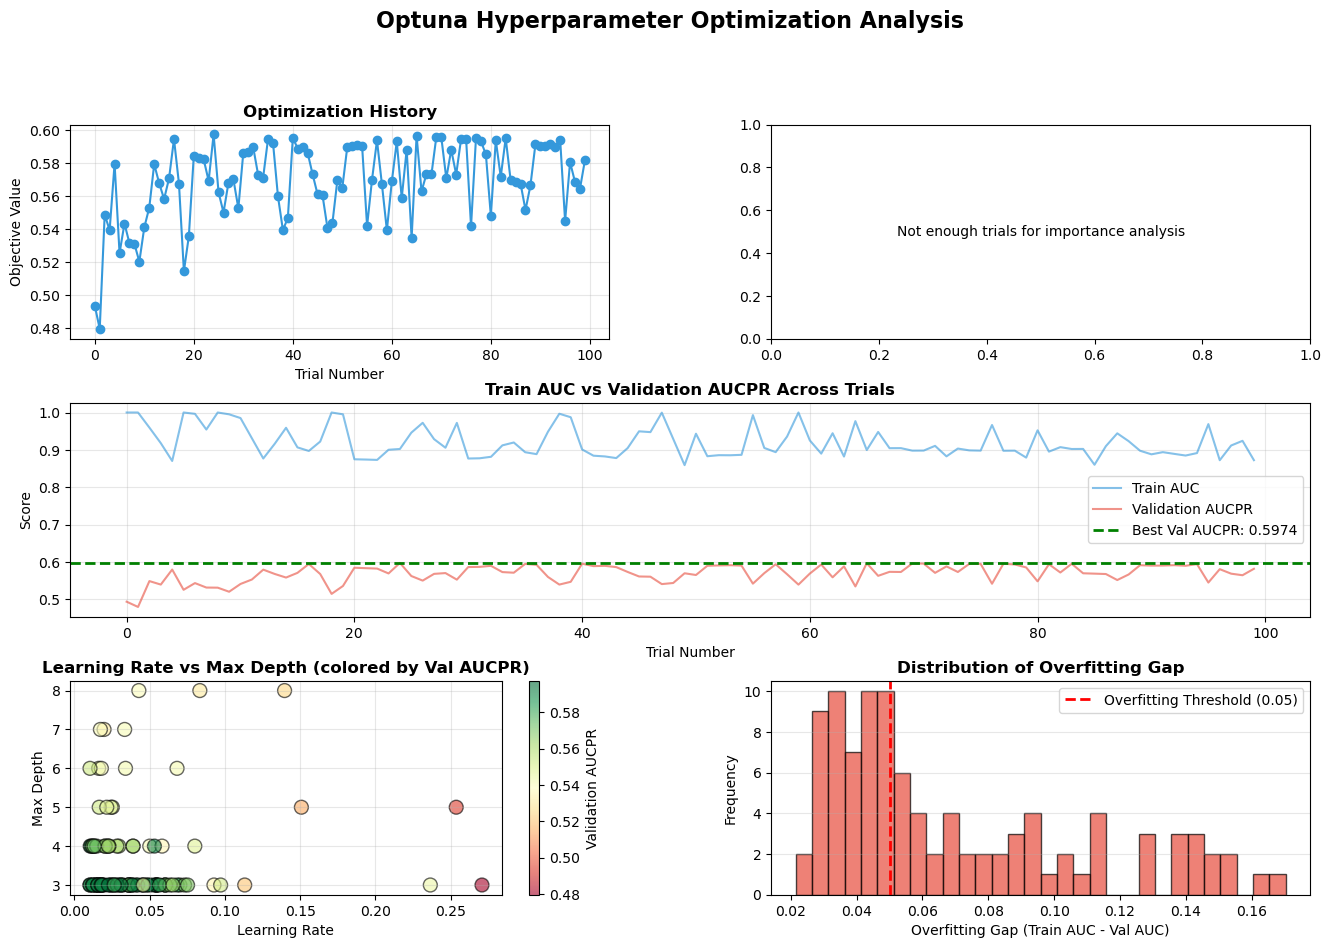

In [25]:
fig_optuna = plt.figure(figsize=(16, 10))
gs_optuna = fig_optuna.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. 优化历史
ax1 = fig_optuna.add_subplot(gs_optuna[0, 0])
# 提取优化历史数据
trial_numbers = [trial.number for trial in study.trials]
objective_values = [trial.value for trial in study.trials]

# 绘制优化历史
ax1.plot(trial_numbers, objective_values, marker='o', linestyle='-', color='#3498db')
ax1.set_title('Optimization History', fontsize=12, fontweight='bold')
ax1.set_xlabel('Trial Number')
ax1.set_ylabel('Objective Value')
ax1.grid(True, alpha=0.3)

# 2. 参数重要性
ax2 = fig_optuna.add_subplot(gs_optuna[0, 1])
try:
    optuna.visualization.matplotlib.plot_param_importances(study, ax=ax2)
    ax2.set_title('Hyperparameter Importance', fontsize=12, fontweight='bold')
except:
    ax2.text(0.5, 0.5, 'Not enough trials for importance analysis', 
             ha='center', va='center', transform=ax2.transAxes)

# 3. 过拟合趋势（改用AUCPR）
ax3 = fig_optuna.add_subplot(gs_optuna[1, :])
train_aucs = [trial.user_attrs.get('mean_train_auc', 0) for trial in study.trials]
val_aucprs = [trial.user_attrs.get('mean_val_aucpr', 0) for trial in study.trials]
trial_numbers = range(len(study.trials))

ax3.plot(trial_numbers, train_aucs, label='Train AUC', alpha=0.6, color='#3498db')
ax3.plot(trial_numbers, val_aucprs, label='Validation AUCPR', alpha=0.6, color='#e74c3c')
ax3.axhline(y=best_score, color='green', linestyle='--', 
            label=f'Best Val AUCPR: {best_score:.4f}', linewidth=2)
ax3.set_xlabel('Trial Number')
ax3.set_ylabel('Score')
ax3.set_title('Train AUC vs Validation AUCPR Across Trials', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. 参数关系（learning_rate vs max_depth，颜色改为AUCPR）
ax4 = fig_optuna.add_subplot(gs_optuna[2, 0])
lr_values = [trial.params.get('learning_rate', 0) for trial in study.trials]
depth_values = [trial.params.get('max_depth', 0) for trial in study.trials]
val_aucprs_scatter = [trial.user_attrs.get('mean_val_aucpr', 0) for trial in study.trials]
scatter = ax4.scatter(lr_values, depth_values, c=val_aucprs_scatter, 
                     cmap='RdYlGn', s=100, alpha=0.6, edgecolors='black')
ax4.set_xlabel('Learning Rate')
ax4.set_ylabel('Max Depth')
ax4.set_title('Learning Rate vs Max Depth (colored by Val AUCPR)', 
              fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax4, label='Validation AUCPR')
ax4.grid(True, alpha=0.3)

# 5. 过拟合差距分布
ax5 = fig_optuna.add_subplot(gs_optuna[2, 1])
overfitting_gaps = [trial.user_attrs.get('overfitting_gap', 0) for trial in study.trials]
ax5.hist(overfitting_gaps, bins=30, color='#e74c3c', alpha=0.7, edgecolor='black')
ax5.axvline(x=0.05, color='red', linestyle='--', 
            label='Overfitting Threshold (0.05)', linewidth=2)
ax5.set_xlabel('Overfitting Gap (Train AUC - Val AUC)')
ax5.set_ylabel('Frequency')
ax5.set_title('Distribution of Overfitting Gap', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

plt.suptitle('Optuna Hyperparameter Optimization Analysis', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()


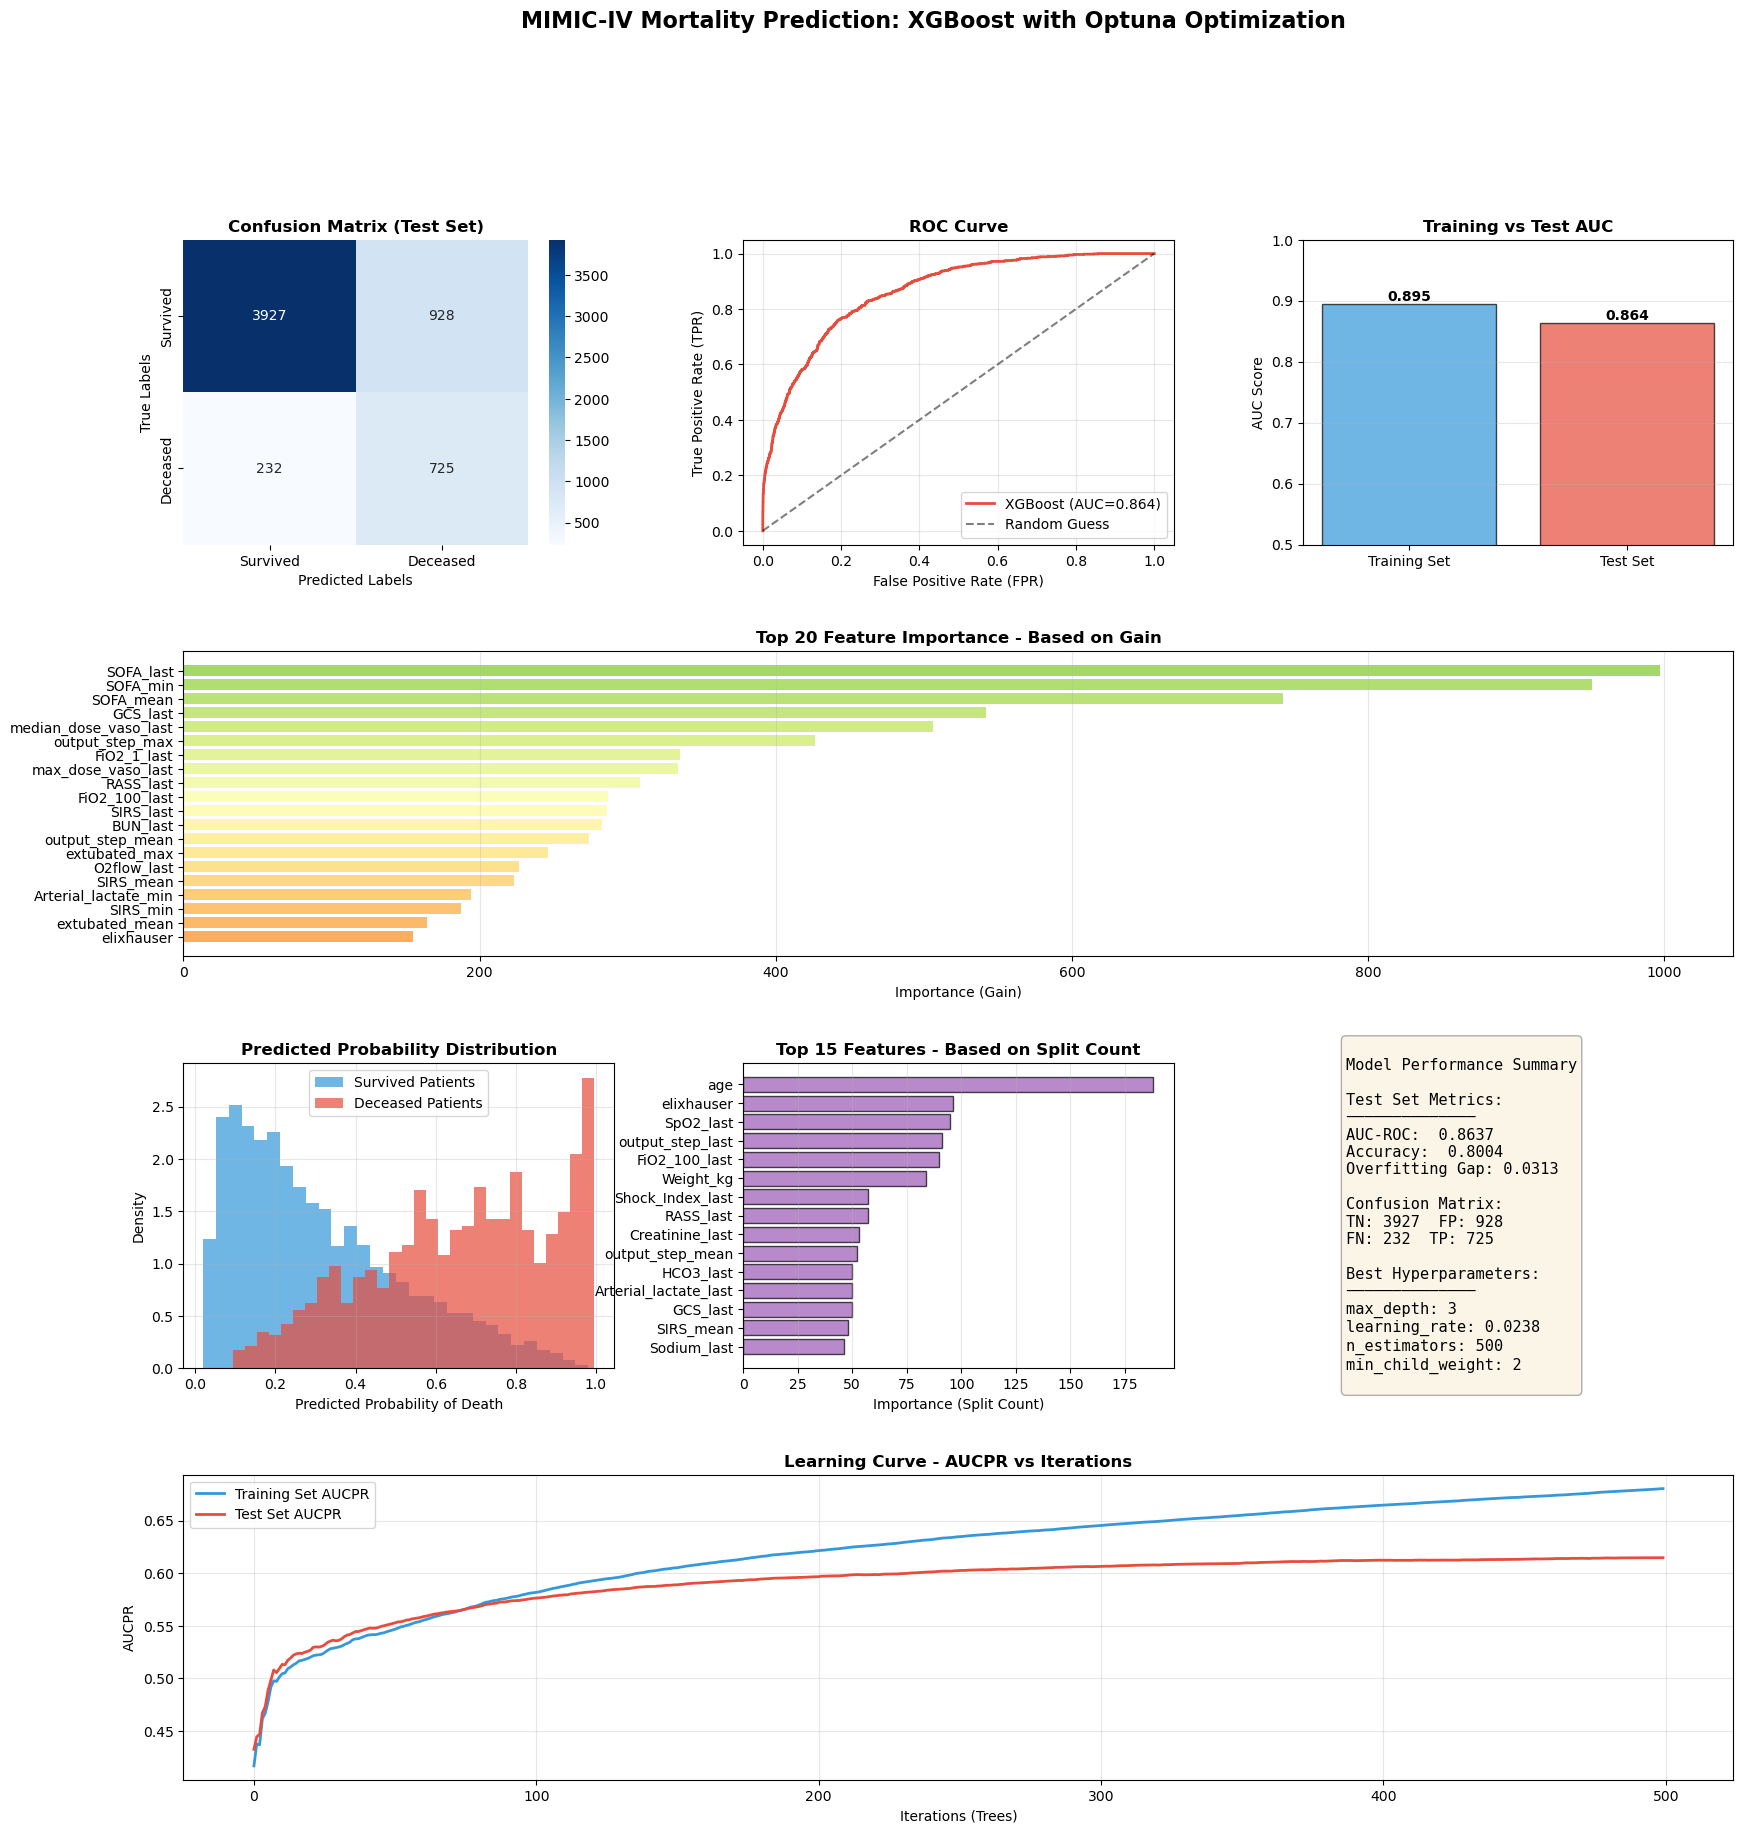

In [26]:
fig = plt.figure(figsize=(20, 20))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Survived', 'Deceased'], 
            yticklabels=['Survived', 'Deceased'])
ax1.set_title('Confusion Matrix (Test Set)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Predicted Labels')
ax1.set_ylabel('True Labels')

# 2. ROC Curve
ax2 = fig.add_subplot(gs[0, 1])
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
ax2.plot(fpr, tpr, label=f'XGBoost (AUC={test_auc:.3f})', 
         linewidth=2, color='#e74c3c')
ax2.plot([0, 1], [0, 1], 'k--', label='Random Guess', alpha=0.5)
ax2.set_xlabel('False Positive Rate (FPR)')
ax2.set_ylabel('True Positive Rate (TPR)')
ax2.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Training vs Test AUC Comparison
ax3 = fig.add_subplot(gs[0, 2])
scores = [train_auc, test_auc]
labels = ['Training Set', 'Test Set']
colors = ['#3498db', '#e74c3c']
bars = ax3.bar(labels, scores, color=colors, alpha=0.7, edgecolor='black')
ax3.set_ylabel('AUC Score')
ax3.set_title('Training vs Test AUC', fontsize=12, fontweight='bold')
ax3.set_ylim([0.5, 1.0])
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# 4. Top 20 Feature Importance (Gain)
ax4 = fig.add_subplot(gs[1, :])
top20 = importance_df.head(20)
colors_feat = plt.cm.RdYlGn_r(np.linspace(0.3, 0.7, len(top20)))
ax4.barh(range(len(top20)), top20['importance_gain'], color=colors_feat)
ax4.set_yticks(range(len(top20)))
ax4.set_yticklabels(top20['feature_name'])
ax4.set_xlabel('Importance (Gain)')
ax4.set_title('Top 20 Feature Importance - Based on Gain', 
              fontsize=12, fontweight='bold')
ax4.invert_yaxis()
ax4.grid(True, axis='x', alpha=0.3)

# 5. Predicted Probability Distribution
ax5 = fig.add_subplot(gs[2, 0])
ax5.hist(y_test_proba[y_test==0], bins=30, alpha=0.7, 
         label='Survived Patients', density=True, color='#3498db')
ax5.hist(y_test_proba[y_test==1], bins=30, alpha=0.7, 
         label='Deceased Patients', density=True, color='#e74c3c')
ax5.set_xlabel('Predicted Probability of Death')
ax5.set_ylabel('Density')
ax5.set_title('Predicted Probability Distribution', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Top 15 Feature Importance (Weight - Split Count)
ax6 = fig.add_subplot(gs[2, 1])
top15_weight = importance_weight_df.head(15)
ax6.barh(range(len(top15_weight)), top15_weight['importance_weight'], 
         color='#9b59b6', alpha=0.7, edgecolor='black')
ax6.set_yticks(range(len(top15_weight)))
ax6.set_yticklabels(top15_weight['feature_name'])
ax6.set_xlabel('Importance (Split Count)')
ax6.set_title('Top 15 Features - Based on Split Count', 
              fontsize=12, fontweight='bold')
ax6.invert_yaxis()
ax6.grid(True, axis='x', alpha=0.3)

# 7. Performance Metrics Summary
test_acc = best_xgb.score(X_test_imputed, y_test)
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('off')
metrics_text = f"""
Model Performance Summary

Test Set Metrics:
──────────────
AUC-ROC:  {test_auc:.4f}
Accuracy:  {test_acc:.4f}
Overfitting Gap: {train_auc - test_auc:.4f}

Confusion Matrix:
TN: {cm[0,0]}  FP: {cm[0,1]}
FN: {cm[1,0]}  TP: {cm[1,1]}

Best Hyperparameters:
──────────────
max_depth: {best_params['max_depth']}
learning_rate: {best_params['learning_rate']:.4f}
n_estimators: {best_params['n_estimators']}
min_child_weight: {best_params['min_child_weight']}
"""
ax7.text(0.1, 0.5, metrics_text, fontsize=11, 
         verticalalignment='center', family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# 8. Learning Curve（同时显示AUC和AUCPR）
ax8 = fig.add_subplot(gs[3, :])
results = best_xgb.evals_result()
epochs = len(results['validation_0']['aucpr'])
x_axis = range(0, epochs)
ax8.plot(x_axis, results['validation_0']['aucpr'], 
         label='Training Set AUCPR', linewidth=2, color='#3498db', linestyle='-')
ax8.plot(x_axis, results['validation_1']['aucpr'], 
         label='Test Set AUCPR', linewidth=2, color='#e74c3c', linestyle='-')
ax8.set_xlabel('Iterations (Trees)')
ax8.set_ylabel('AUCPR')
ax8.set_title('Learning Curve - AUCPR vs Iterations', fontsize=12, fontweight='bold')
ax8.legend()
ax8.grid(True, alpha=0.3)

plt.suptitle('MIMIC-IV Mortality Prediction: XGBoost with Optuna Optimization', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()